In [1]:
import numpy as np
import xray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm

In [2]:
import xgcm
import jmd95

In [3]:
ddir = '/home/rpa/MITgcm/verification/global_oce_latlon_layers/run'

iters = [39600,]
ds = xgcm.open_mdsdataset(ddir, iters, deltaT=86400, 
                             prefix=['DiagGAD-T', 'DiagGAD-S','DiagGAD-PTR','T','S','DiagSurf-TS']).chunk()
ds

/home/rpa/xgcm/xgcm/mdsxray.py:205: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/rpa/xgcm/xgcm/mdsxray.py:205: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xray.Dataset>
Dimensions:   (X: 90, Xp1: 90, Y: 40, Yp1: 40, Z: 15, Zl: 15, Zp1: 16, Zu: 15, time: 1)
Coordinates:
  * Xp1       (Xp1) >f4 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 40.0 ...
  * Zl        (Zl) >f4 0.0 -50.0 -120.0 -220.0 -360.0 -550.0 -790.0 -1080.0 ...
  * Yp1       (Yp1) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 -56.0 -52.0 ...
  * Zp1       (Zp1) >f4 0.0 -50.0 -120.0 -220.0 -360.0 -550.0 -790.0 -1080.0 ...
  * Y         (Y) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 -46.0 ...
  * X         (X) >f4 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 42.0 ...
  * Z         (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 -1250.0 ...
  * Zu        (Zu) >f4 -50.0 -120.0 -220.0 -360.0 -550.0 -790.0 -1080.0 ...
  * time      (time) int64 3421440000
Data variables:
    YC        (Y, X) >f4 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 ...
    YG        (Yp1, Xp1) >f4 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 -80.0 ...
    rA        (Y, X) >f4 4.11097e+10 4.

In [4]:
gcm = xgcm.GCMDataset(ds)

In [5]:

def calc_budget(self, trname='TH'):
    """Add mixing and cabbeling tendencies to Dataset ds"""

    # divergence of diffusive fluxes
    diffusion_horizontal = (
        self.diff_xp1_to_x(self.ds['DFxE_' + trname]) +
        self.diff_yp1_to_y(self.ds['DFyE_' + trname])
    ).rename('diffusion_horizontal')
    
    # now turn that into a dataset
    ds = diffusion_horizontal.to_dataset()
    
    ds['diffusion_vertical'] = (
        self.diff_zl_to_z(self.ds['DFrE_' + trname]) +
        self.diff_zl_to_z(self.ds['DFrI_' + trname])
    )
    
    # divergence of horizontal fluxes
    ds['advection_horizontal'] = (
        self.diff_xp1_to_x(self.ds['ADVx_' + trname]) +
        self.diff_yp1_to_y(self.ds['ADVy_' + trname])
    )
    ds['advection_vertical'] = (
        self.diff_zl_to_z(self.ds['ADVr_' + trname]) 
    )
    
    net = 0
    for v in ds.data_vars:
        net += ds[v]
    ds['net'] = net
    
    return ds


In [6]:
th_budget = calc_budget(gcm, 'TH')

In [7]:
th_budget

<xray.Dataset>
Dimensions:               (X: 90, Y: 40, Z: 15, time: 1)
Coordinates:
  * Y                     (Y) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 ...
  * X                     (X) >f4 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 ...
  * Z                     (Z) >f4 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 ...
  * time                  (time) int64 3421440000
Data variables:
    diffusion_horizontal  (time, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    diffusion_vertical    (time, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    advection_horizontal  (time, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    advection_vertical    (time, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    net                   (time, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...

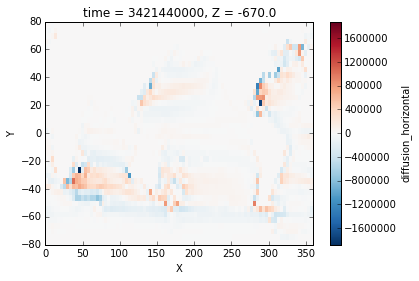

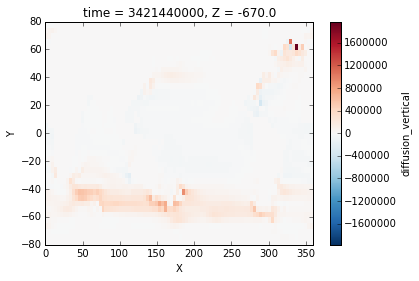

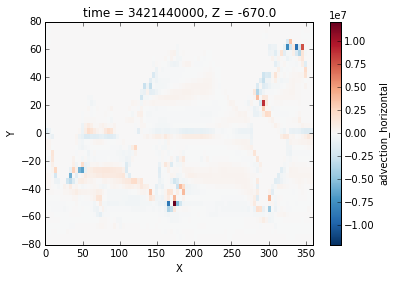

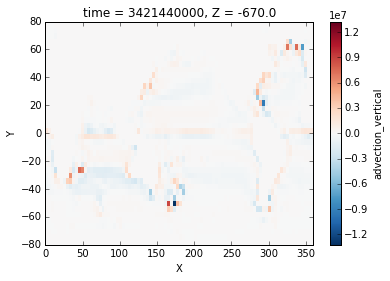

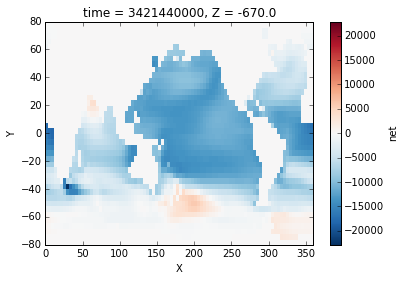

In [8]:
for v in th_budget.data_vars:
    plt.figure()
    th_budget[v][0,5].plot.pcolormesh()